# Gradient verification for the 1D - non reactive transport (diffusion + advection), permeability inversion from head observations 

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
from pathlib import Path
import os
import logging
import copy
from typing import Generator, Iterable
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
from pyrtid.utils import indices_to_node_number, node_number_to_indices
import nested_grid_plotter as ngp
import scipy as sp
from pyrtid.plot import plot_observed_vs_simulated
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import numpy as np
import gstools as gs
from pyrtid.utils import (
    NDArrayFloat,
    NDArrayInt,
    gen_random_ensemble,
    node_number_to_indices,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a test")

INFO:root:this is a test


- Check package/software versions

In [3]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [5]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [6]:
nx = 40  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
dx = 9.3  # voxel dimension along the x axis
dy = 8.45  # voxel dimension along the y axis

# Time parameters
duration_in_d = 7.0  # duration in days
duration_in_s = duration_in_d * 3600 * 24
dt_init = 3600 * 6  # timestep in seconds
dt_max = dt_init
dt_min = dt_init

c0 = 0  # general initial cocentration
# Hydro parameters
D0 = 1e-4  # general initial diffusion coefficient [m2/s]
k0 = 1e-4  # general permeability
w0 = 0.23  # general porosity [fraction]
# Chemistry parameters
c0 = 0.0  # general initial concentration [molal]
c_inj = 1e-5  # molal
storage_coefficient = 1e-3
# Values for the x axis ()meters
x_positions_in_meters: NDArrayFloat = np.arange(nx) * dx + dx / 2

In [7]:
courant_factor = 20
crank_nicolson = 0.8  # enough to ensure stability and test "semi-implcit"
flow_regime = "transient"
cst_head_left = 20  # m
cst_head_right = -30  # m

- x_coordinates array for the plots

In [8]:
x_coordinates = (np.arange(nx) + 0.5) * dx

- Three observation wells

In [9]:
production_locations = [12, 28]
injection_locations = [4, 20, 36]

- Create an reference and an initial estimate distribution for the permebility

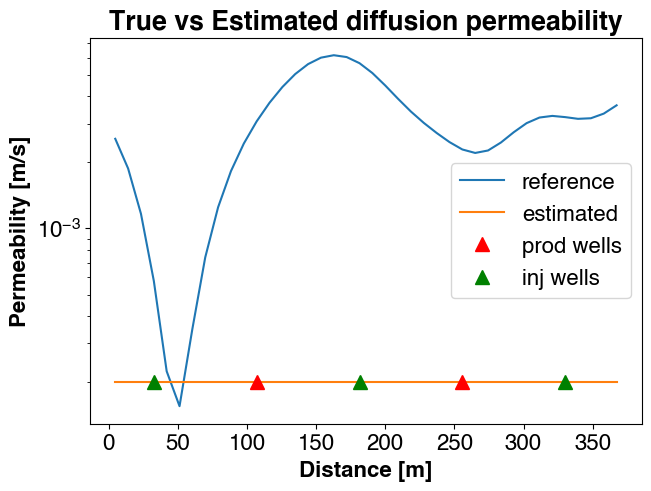

In [10]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 6

min_val = 2e-4
max_val = 1e-2
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
mean = (max_val + min_val) / 2.5
stdev = (max_val - min_val) / 3.0 / 2.0  # std ~ 1/6 of the distribution interval
len_scale: float = 5.0

perm_reference = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    seed=seed,
)[0, :, :, 0]


# Initial estimate = an homogeneous value
perm_estimate = np.ones((nx, ny)) * min_val  # m2/s
# perm_reference = np.ones((nx, ny)) * min_val * 4  # m2/s

plotter = ngp.NestedGridPlotter()
ax = plotter.ax_dict["ax1-1"]

ax.set_xlabel("Distance [m]", fontweight="bold")
ax.set_ylabel("Permeability [m/s]", fontweight="bold")
ax.set_yscale("log")
ax.set_title("True vs Estimated diffusion permeability", fontweight="bold")
plotter.fig.set_facecolor("w")


ax.plot(x_positions_in_meters, perm_reference, label="reference")
ax.plot(x_positions_in_meters, perm_estimate, label="estimated")

# Add some vertical lines to indicate the well
for well_pos in production_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        min_val,
        label="prod wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

for well_pos in injection_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        min_val,
        label="inj wells",
        marker="^",
        markersize=10,
        c="g",
        linestyle="none",
    )

plotter.add_axis_legend("ax1-1")

fname = "true_vs_estimated_initial_permeability"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Note: The assays take place over 5 days: for each day, on well inject or pump at 6 m3/h, while the head is observed at the others

### Forward problem in demonstrator

In [11]:
# Simulation on 31 days. We use a 4h timestep.
time_params = dmfwd.TimeParameters(
    duration=duration_in_s,
    dt_init=dt_init,
    dt_max=dt_max,
    dt_min=dt_min,
    courant_factor=courant_factor,
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy)
fl_params = dmfwd.FlowParameters(
    permeability=k0,
    storage_coefficient=storage_coefficient,
    regime={
        "stationary": dmfwd.FlowRegime.STATIONARY,
        "transient": dmfwd.FlowRegime.TRANSIENT,
    }[flow_regime],
    crank_nicolson=crank_nicolson,
)

base_model = dmfwd.ForwardModel(geometry, time_params, fl_params)

- Add boundary conditions and regional recharge

In [12]:
# Boundary conditions
base_model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(0, 1), slice(None))))
base_model.fl_model.lhead[0][0, :] = cst_head_left
base_model.add_boundary_conditions(
    dmfwd.ConstantHead(span=(slice(nx - 1, nx), slice(None)))
)
base_model.fl_model.lhead[0][-1, :] = cst_head_right

- Create the source terms for the pumping: one pumping test per day at -25 m3/h

In [13]:
day = 0
prod_flw = -8.0 / 3600  # 8 m3/h

# two successive pumping on days 1 and 2
for loc in production_locations:
    day += 1
    sink_term = dmfwd.SourceTerm(
        "producer loc # {loc}",
        node_ids=np.array(indices_to_node_number(ix=loc, nx=nx)),
        # pumping on 1 day
        times=np.array([day, day + 1], dtype=np.float64) * 3600 * 24,
        flowrates=np.array([prod_flw, 0.0]),
        concentrations=np.array([[0.0, 0.0], [0.0, 0.0]]),
    )
    base_model.add_src_term(sink_term)

n_prod_linked_list = [1, 2, 1]

# three successive injections on days 3, 4 and 5
for i, loc in enumerate(injection_locations):
    day += 1
    source_term = dmfwd.SourceTerm(
        "injector loc # {loc}",
        node_ids=np.array(indices_to_node_number(ix=loc, nx=nx)),
        times=np.array([day, day + 1], dtype=np.float64) * 3600 * 24,
        flowrates=np.array([-prod_flw, 0.0]),
        concentrations=np.array([[0.0, 0.0], [0.0, 0.0]]),
    )
    base_model.add_src_term(source_term)

- Create two models with different permeabilities

In [14]:
# copy the base model
model_reference = copy.deepcopy(base_model)
# update permeability
model_reference.fl_model.permeability = perm_reference
# solve the flow problem
dmfwd.ForwardSolver(model_reference).solve()

In [15]:
# copy the base model
model_estimate = copy.deepcopy(base_model)
# update permeability
model_estimate.fl_model.permeability = perm_estimate
# solve the flow problem
dmfwd.ForwardSolver(model_estimate).solve()

- Check that the sources have been correctly defined: we plot the flowrate within time for the 30 wells: we see 30 intervals

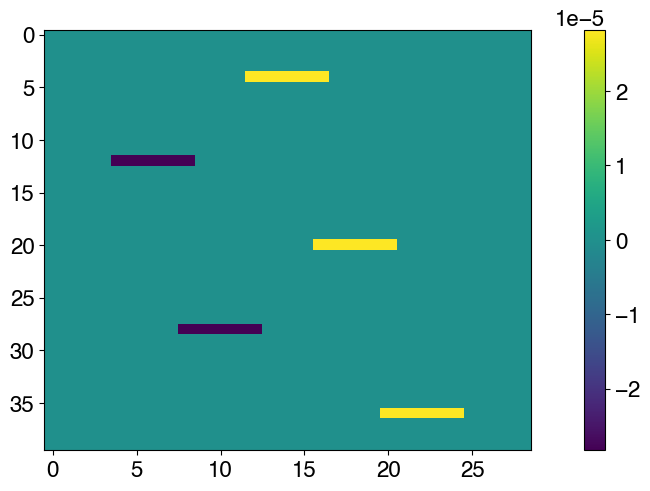

In [16]:
plt.imshow(model_estimate.fl_model.unitflow[:, 0, :], aspect="auto")
plt.colorbar()

- Top view

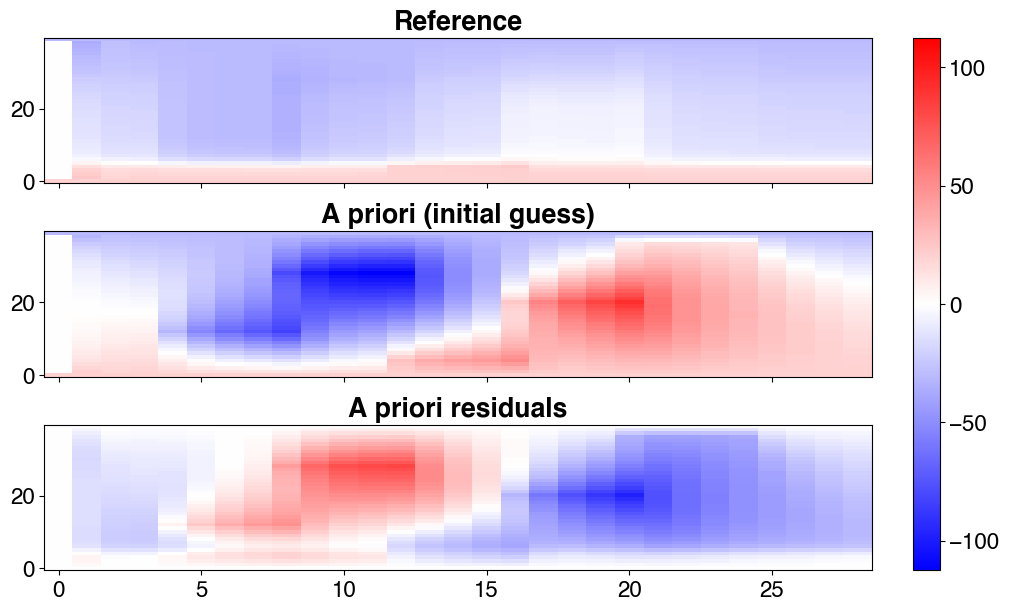

In [17]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference": model_reference.fl_model.head[:, 0, :].T,
        "A priori (initial guess)": model_estimate.fl_model.head[:, 0, :].T,
        "A priori residuals": (
            model_reference.fl_model.head[:, 0, :].T
            - model_estimate.fl_model.head[:, 0, :].T
        ),
    },
    is_symmetric_cbar=True,
)

fname = "head_ref_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Forward variables at the producer locations

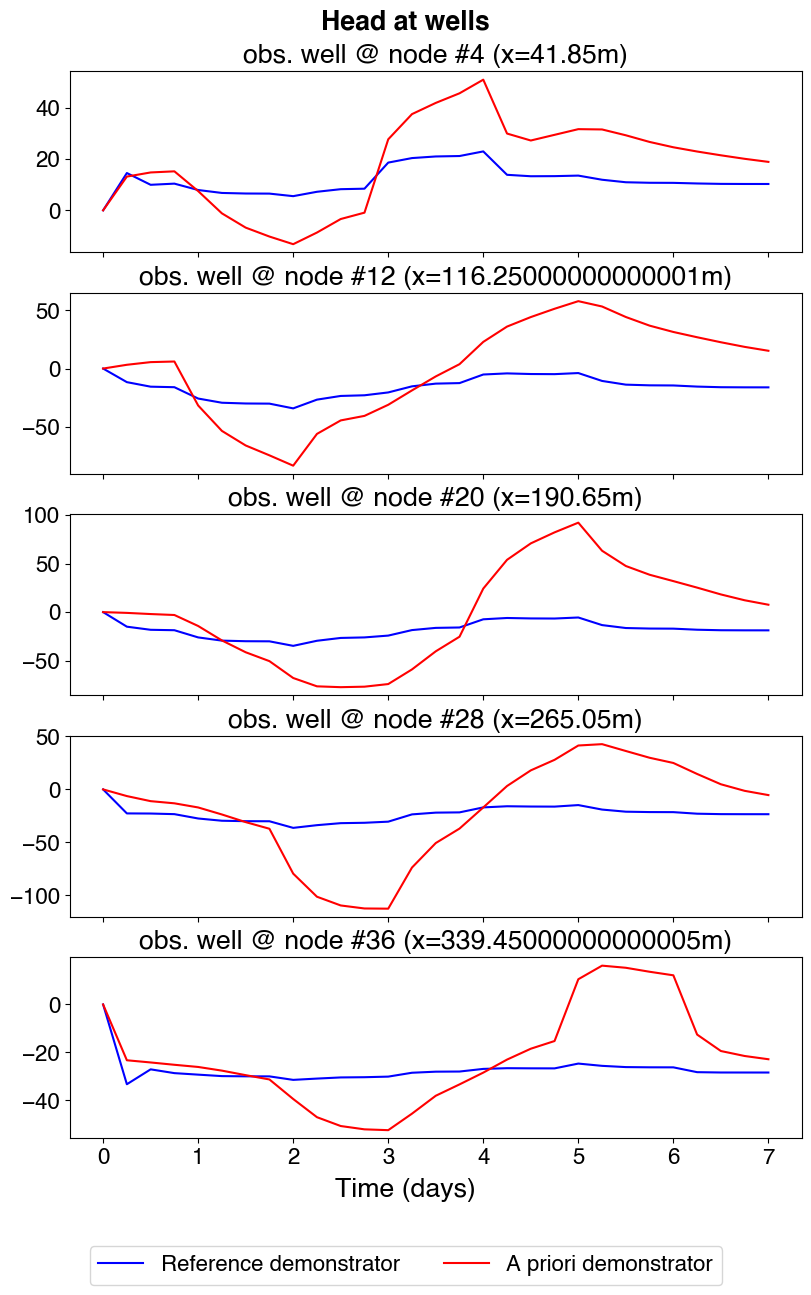

In [18]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, node_id in enumerate(sorted(production_locations + injection_locations)):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.time_params.times / 3600 / 24,
        model_reference.fl_model.head[node_id, 0, :],
        label="Reference demonstrator",
        c="b",
    )
    ax.plot(
        model_estimate.time_params.times / 3600 / 24,
        model_estimate.fl_model.head[node_id, 0, :],
        label="A priori demonstrator",
        c="r",
    )

plotter.fig.supxlabel("Time (days)")
plotter.fig.suptitle("Head at wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=0.0)

fname = "head_ref_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [19]:
# function for time display
# plot the time
def get_time(nb_frames: int) -> Generator[str, None, None]:
    ts_btw_frames = model_estimate.time_params.nt / nb_frames
    for frame in range(nb_frames):
        yield f"time = {model_estimate.time_params.times[int(ts_btw_frames * frame)] / 3600:.3f} h"

In [20]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

# Animated plot
nb_frames = min(20, model_reference.time_params.nt)

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "True": {
            "x": x_coordinates,
            "y": model_reference.fl_model.head[:, 0, :],
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "x": x_coordinates,
            "y": model_estimate.fl_model.head[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Pyrtid",
    xlabel="X [m]",
)

for ax_name in ["ax1-1"]:
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx
            - dx / 2,  # Well pos + 1 because of indexing that starts at zero
            0.0,
            label="prod wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    for well_pos in injection_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx - dx / 2,
            0.0,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

    plotter.plot_animated_text(
        ax=plotter.get_axis(ax_name),
        x=0.83,
        y=0.92,
        s=list(get_time(nb_frames)),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis(ax_name).transAxes,
        fontsize=14,
        fontweight="bold",
    )

    plotter.add_axis_legend(ax_name, loc="upper left")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Inversion

We sample heads in the first half of the simulation, and pressure in the second half of the simulation so we can test the implementation with both. We also add a small overlap (2 observations).


In [21]:
freq_measure_in_d = 0.5  # one measure every two days
n_sampled_days = duration_in_d / freq_measure_in_d

obs_times_in_s = np.arange(n_sampled_days) * 3600 * 24 * freq_measure_in_d

obs_times_in_s_head = obs_times_in_s[: int(n_sampled_days / 2) + 1]
obs_times_in_s_pressure = obs_times_in_s[int(n_sampled_days / 2) - 1 :]

logging.info(f"obs_times_in_s_head = {obs_times_in_s_head}")
logging.info(f"obs_times_in_s_pressure = {obs_times_in_s_pressure}")

INFO:root:obs_times_in_s_head = [     0.  43200.  86400. 129600. 172800. 216000. 259200. 302400.]
INFO:root:obs_times_in_s_pressure = [259200. 302400. 345600. 388800. 432000. 475200. 518400. 561600.]


In [22]:
noise_std_head: float = 1.5  # This is an absolute value in m
noise_std_pressure: float = 1.0 * 1e4  # This is an absolute value in Pa


def get_white_noise(shape: Iterable[int], noise_std: float) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise_head: NDArrayFloat = get_white_noise(
    (len(production_locations), obs_times_in_s_head.size), noise_std_head
)
obs_noise_pressure: NDArrayFloat = get_white_noise(
    (len(production_locations), obs_times_in_s_pressure.size), noise_std_pressure
)

- Check the intensity of the noise for the head

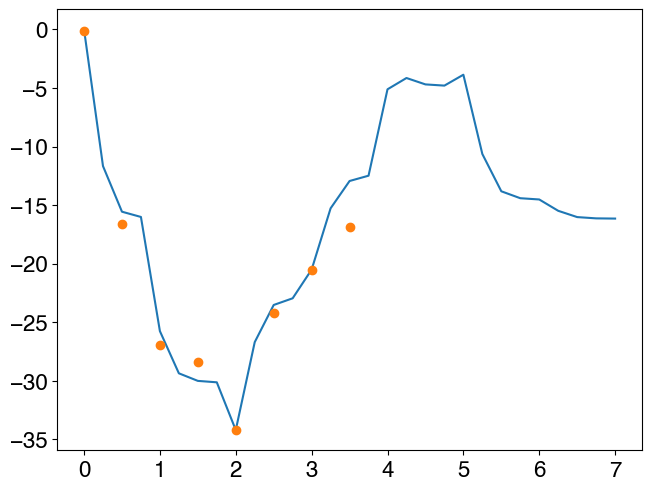

In [23]:
all_times = model_estimate.time_params.times

obs_values_head = np.zeros((len(production_locations), obs_times_in_s_head.size))

for count, ix in enumerate(production_locations):
    # interpolate the values
    obs_values_head[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.fl_model.head[ix, 0, :], kind="cubic"
        )(obs_times_in_s_head)
        + obs_noise_head[count, :]
    )

count = 0

ix = production_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.fl_model.head[ix, 0, :])
plt.plot(
    obs_times_in_s_head / 3600 / 24,
    obs_values_head[count],
    marker="o",
    linestyle="none",
)

- Check the intensity of the noise for the pressure

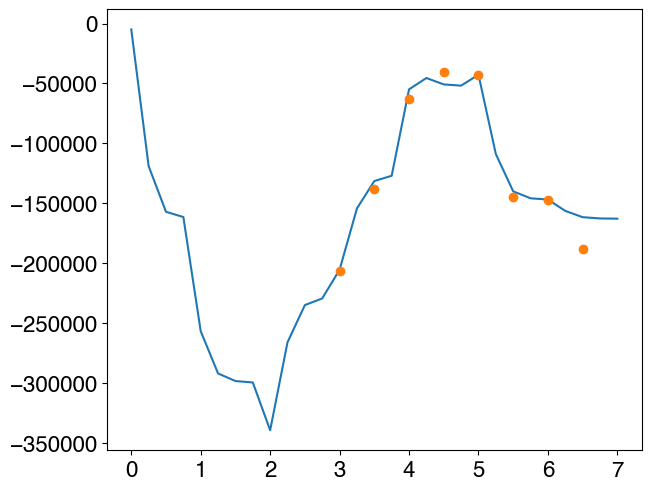

In [24]:
obs_values_pressure = np.zeros(
    (len(production_locations), obs_times_in_s_pressure.size)
)

for count, ix in enumerate(production_locations):
    # interpolate the values
    obs_values_pressure[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.fl_model.pressure[ix, 0, :], kind="cubic"
        )(obs_times_in_s_pressure)
        + obs_noise_pressure[count, :]
    )

count = 0

ix = production_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.fl_model.pressure[ix, 0, :])
plt.plot(
    obs_times_in_s_pressure / 3600 / 24,
    obs_values_pressure[count],
    marker="o",
    linestyle="none",
)

## Gradient with respect to the permeability


In [25]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    # /10 to avoid finite differences fail because of bounds clipping
    lbounds=min_val / 10,
    # * 10 to avoid finite differences fail because of bounds clipping
    ubounds=max_val * 10,
    preconditioner=dminv.LogTransform(),
)

observables = []
for i, node_id in enumerate(production_locations):
    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.HEAD,
            node_indices=node_id,
            times=obs_times_in_s_head,
            values=obs_values_head[i],
            uncertainties=noise_std_head,
        )
    )

    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.PRESSURE,
            node_indices=node_id,
            times=obs_times_in_s_pressure,
            values=obs_values_pressure[i],
            uncertainties=noise_std_pressure,
        )
    )

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-15,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

executor.eval_scaled_loss(param.preconditioner(param.values))

is_grad_ok = executor.is_adjoint_gradient_correct(max_workers=4, is_verbose=False)

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 624.5612089508543
INFO:root:Loss (regularization) = 0.0
INFO:root:Regularization weight = 0.0
INFO:root:Scaling factor        = 0.0016011240942738222
INFO:root:Loss (scaled)         = 1.0



gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out


In [26]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


In [27]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

# Static plot
for ax_name in ["ax1-1"]:
    plotter.get_axis(ax_name).plot(
        x_positions_in_meters, [0.0] * nx, c="red", label="Initial"
    )


# Animated plot
nb_frames = min(30, model_estimate.time_params.nt)

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "Adj": {
            "x": x_positions_in_meters,
            "y": executor.adj_model.a_fl_model.a_head[:, 0, ::-1],
            "kwargs": {"c": "blue"},
        },
    },
    nb_frames=nb_frames,
    title="PyRTID adjoint head",
    xlabel="X [m]",
)


plotter.plot_animated_text(
    ax=plotter.ax_dict["ax1-1"],
    x=0.2,
    y=0.9,
    s=list(get_time(nb_frames)),
    horizontalalignment="center",
    verticalalignment="center",
    transform=plotter.ax_dict["ax1-1"].transAxes,
    fontsize=14,
    fontweight="bold",
)

for ax_name in ["ax1-1"]:
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx
            - dx / 2,  # Well pos + 1 because of indexing that starts at zero
            min_val,
            label="prod wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    for well_pos in injection_locations:
        plotter.get_axis(ax_name).plot(
            (well_pos + 1) * dx - dx / 2,
            min_val,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

    plotter.add_axis_legend(ax_name, loc="upper right")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("adjconc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


### Results comparison

The adjoint concentrations should be quite the same both in shape and intensity.

In [28]:
executor.adj_model.a_fl_model.a_head.shape

(40, 1, 29)

In [29]:
executor.adj_model.a_fl_model.a_head.shape

(40, 1, 29)

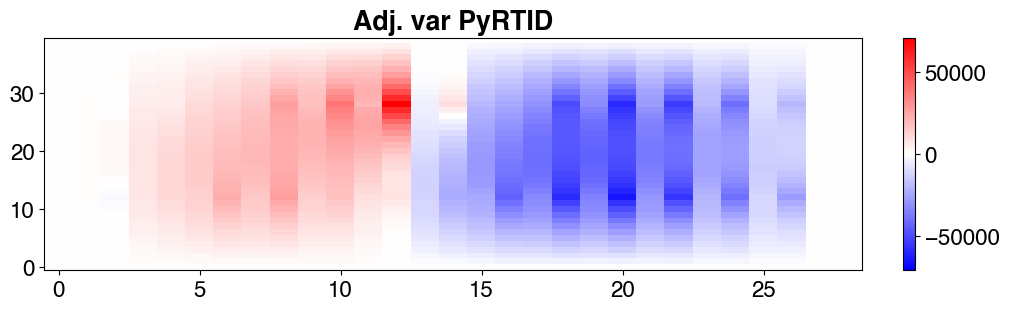

In [30]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 3)},
    subplots_mosaic_params={"fig0": dict(mosaic=[["ax1-1"]], sharey=True, sharex=True)},
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Adj. var PyRTID": executor.adj_model.a_fl_model.a_head[:, 0, :].T,
    },
    is_symmetric_cbar=True,
)

fname = "adjoint_concentrations_dem_vs_hytec_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

Let's check the adjoint variables at the three observation wells. Note that only the right one has been used as an adjoint source (node_id == 15).

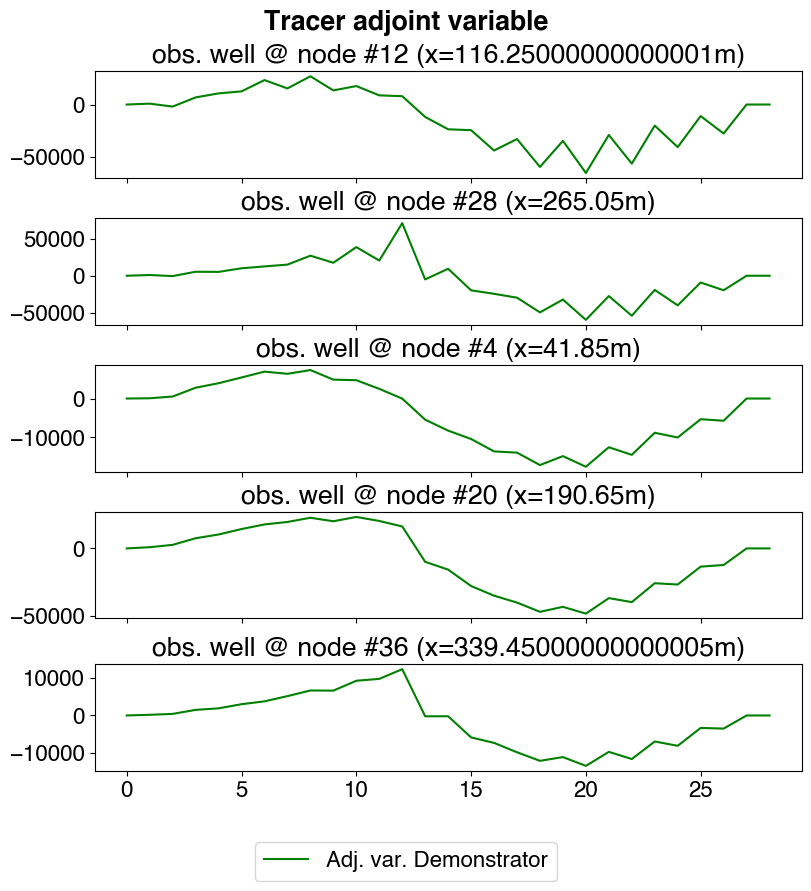

In [31]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, node_id in enumerate(production_locations + injection_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        executor.adj_model.a_fl_model.a_head[node_id, 0, :],
        label="Adj. var. Demonstrator",
        c="g",
    )


plotter.fig.suptitle("Tracer adjoint variable", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "adjoint_concentrations_dem_vs_hytec_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Get the gradients by the adjoint method and finite differences

Finally, plot the gradients comparison.

In [32]:
executor.inv_model.scaling_factor

0.0016011240942738222

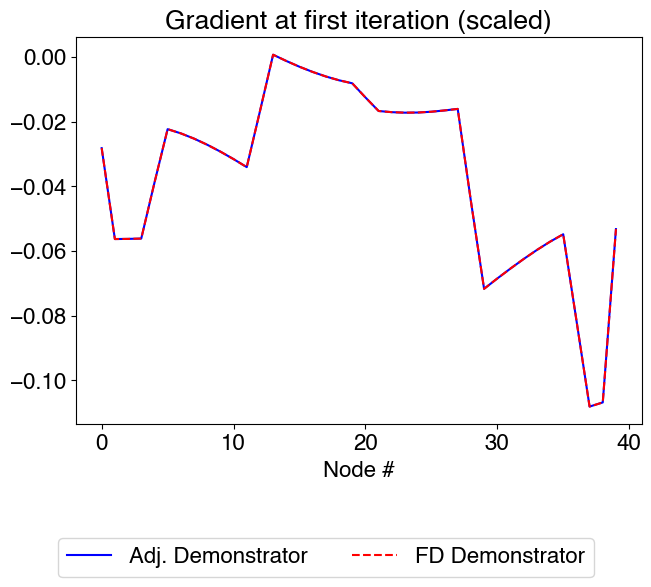

In [33]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

# Demonstrator (PyRTID)
ax.plot(
    param.grad_adj_history[0] * executor.inv_model.scaling_factor,
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param.grad_fd_history[0] * executor.inv_model.scaling_factor,
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)

ax.set_title("Gradient at first iteration (scaled)")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [34]:
param.grad_adj_history[0] / param.grad_fd_history[0]

array([[0.99999999],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99999999],
       [0.99999999],
       [1.00000001],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99999998],
       [1.00000035],
       [0.99999998],
       [0.99999991],
       [0.99999994],
       [0.99999998],
       [1.        ],
       [0.99999996],
       [1.        ],
       [0.99999999],
       [1.        ],
       [0.99999999],
       [0.99999998],
       [0.99999999],
       [0.99999998],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ]])

- Plot the residuals: note in HYTEC we have zero probably because of the number of digits used to save the gradient

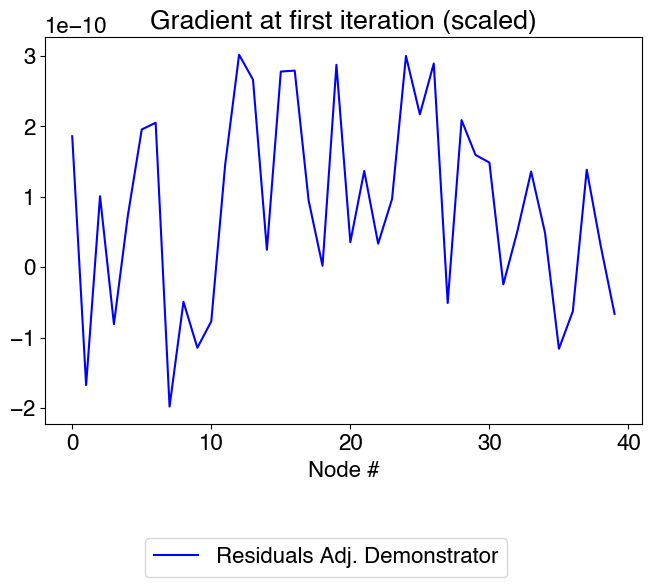

In [35]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

# Demonstrator (PyRTID)
ax.plot(
    (param.grad_adj_history[0] - param.grad_fd_history[0])
    * executor.inv_model.scaling_factor,
    label="Residuals Adj. Demonstrator",
    c="b",
)

ax.set_title("Gradient at first iteration (scaled)")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Gradient with respect to initial head

In [36]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.INITIAL_HEAD,
    # /10 to avoid finite differences fail because of bounds clipping
    lbounds=-100,
    # * 10 to avoid finite differences fail because of bounds clipping
    ubounds=100,
)

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-15,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

executor.eval_scaled_loss(param.preconditioner(param.values))

is_grad_ok = executor.is_adjoint_gradient_correct(
    max_workers=4, is_verbose=False, eps=1e-4
)

INFO:root:- Running forward model # 1


INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 624.5612089508528
INFO:root:Loss (regularization) = 0.0
INFO:root:Regularization weight = 0.0
INFO:root:Scaling factor        = 0.001601124094273826
INFO:root:Loss (scaled)         = 0.9999999999999999



gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out


In [37]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


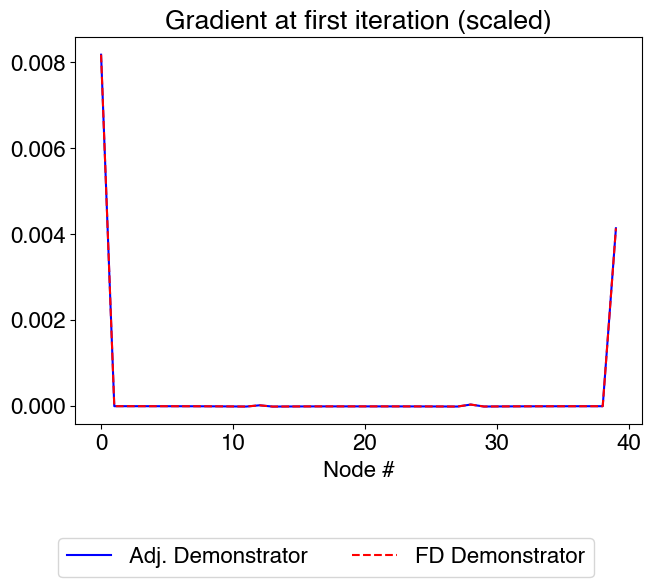

In [38]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

# Demonstrator (PyRTID)
ax.plot(
    param.grad_adj_history[0] * executor.inv_model.scaling_factor,
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param.grad_fd_history[0] * executor.inv_model.scaling_factor,
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)

ax.set_title("Gradient at first iteration (scaled)")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [39]:
param.grad_adj_history[0].ravel() / param.grad_fd_history[0].ravel()

array([1.        , 1.00019841, 1.00003053, 1.00003304, 0.99998941,
       1.0000089 , 0.99998261, 1.00000237, 0.9999973 , 0.99999785,
       0.99999939, 0.99999971, 1.00000035, 0.99999986, 1.00000007,
       1.00000026, 0.99999882, 1.00000013, 1.00000254, 1.00000011,
       0.99999938, 1.00000057, 1.00000061, 1.00000076, 1.00000292,
       0.99999883, 0.99999929, 0.99999888, 0.99999981, 0.99999917,
       0.99999838, 1.00000066, 1.00000023, 0.99999739, 1.00000364,
       0.99999953, 1.00000339, 1.00000824, 1.00002094, 1.        ])

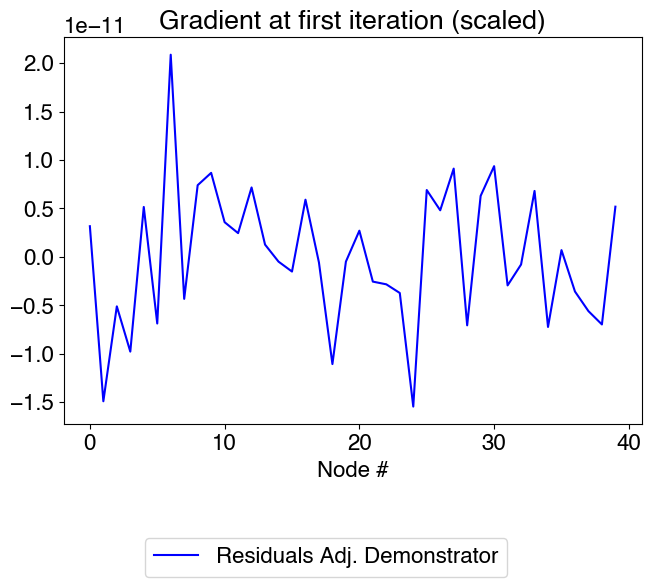

In [40]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

# Demonstrator (PyRTID)
ax.plot(
    (param.grad_adj_history[0] - param.grad_fd_history[0])
    * executor.inv_model.scaling_factor,
    label="Residuals Adj. Demonstrator",
    c="b",
)

ax.set_title("Gradient at first iteration (scaled)")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Gradient with respect to the storage coefficient

In [41]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.STORAGE_COEFFICIENT,
    # /10 to avoid finite differences fail because of bounds clipping
    lbounds=1e-6,
    # * 10 to avoid finite differences fail because of bounds clipping
    ubounds=1e-1,
    preconditioner=dminv.LogTransform(),
)

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-15,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = dminv.InverseModel(param, observables)
executor = dminv.ScipyInversionExecutor(model_adjusted, inverse_model, solver_config)

executor.eval_scaled_loss(param.preconditioner(param.values))

is_grad_ok = executor.is_adjoint_gradient_correct(
    max_workers=4, is_verbose=False, eps=1e-6
)

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 624.5612089508531
INFO:root:Loss (regularization) = 0.0
INFO:root:Regularization weight = 0.0
INFO:root:Scaling factor        = 0.001601124094273825
INFO:root:Loss (scaled)         = 0.9999999999999999



gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out
gmres in
gmres out


In [42]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


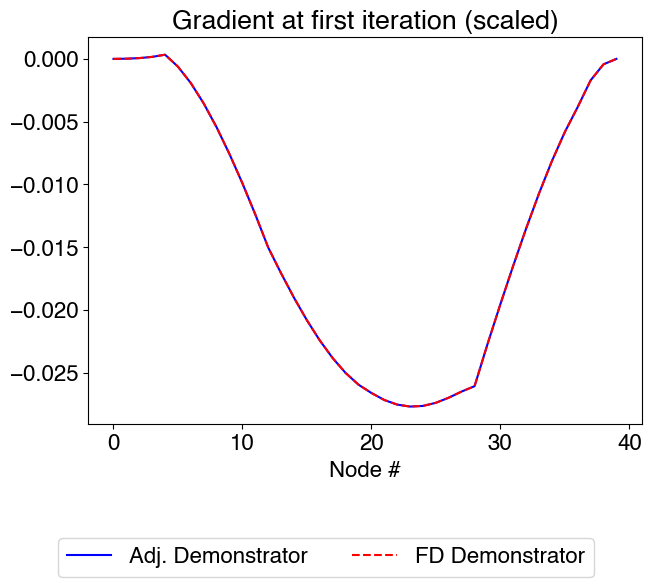

In [43]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

# Demonstrator (PyRTID)
ax.plot(
    param.grad_adj_history[0] * executor.inv_model.scaling_factor,
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param.grad_fd_history[0] * executor.inv_model.scaling_factor,
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)

ax.set_title("Gradient at first iteration (scaled)")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

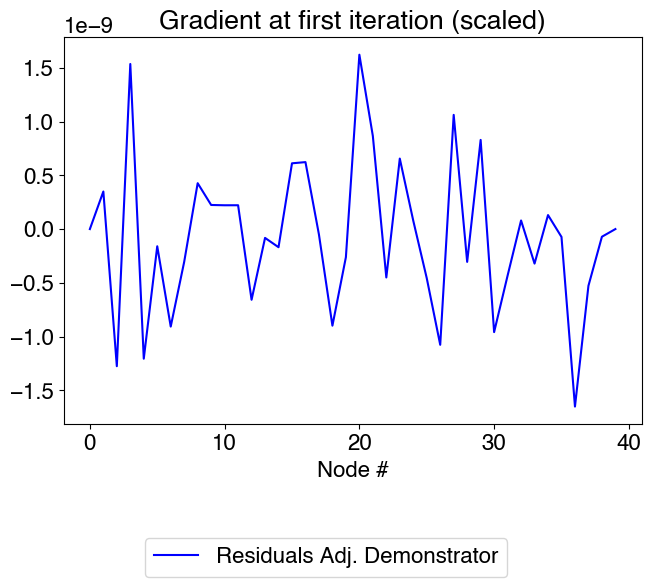

In [44]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()
# The gradient saved by HYTEC takes into account the scaling factor. See if it is required or not ??? -> yes for the hessian

ax = plotter.get_axis("ax1-1")

# Demonstrator (PyRTID)
ax.plot(
    (param.grad_adj_history[0] - param.grad_fd_history[0])
    * executor.inv_model.scaling_factor,
    label="Residuals Adj. Demonstrator",
    c="b",
)

ax.set_title("Gradient at first iteration (scaled)")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)